# 使用回归分析预测连续性目标变量

## 介绍简单的线性回归模型

simple linear regression

$$y = w_0 + w_1x$$

multiple linear regression

$$y = w_0x_0 + w_1x_1 + \ldots + w_mx_m = \sum_{i=0}^{m} w_ix_i = w^Tx$$

## 探索房屋数据集

In [143]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### 可视化数据集中重要的特征

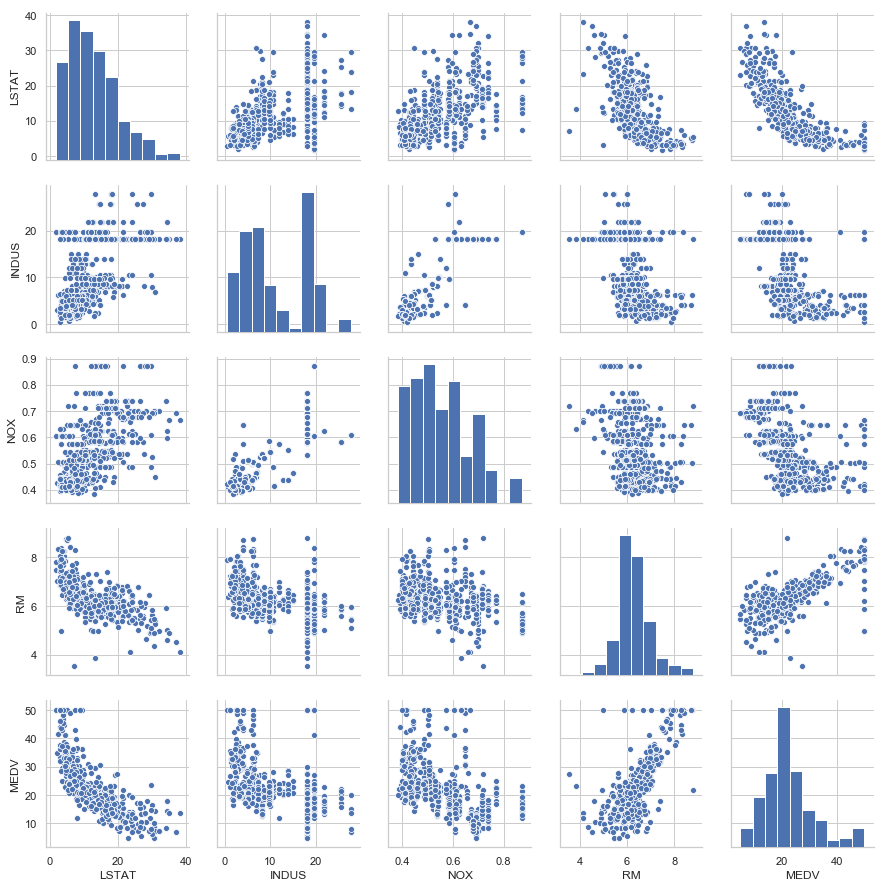

In [144]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height=2.5)


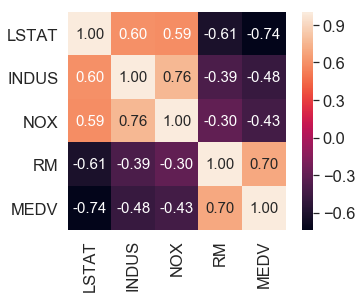

In [145]:
# 通过corrcoef和heatmap查看上述5个特征的关联程度
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 15}, yticklabels=cols, xticklabels=cols)


In [146]:
sns.reset_orig()

D:\Software\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
D:\Software\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


## 实现一个普通最小二乘线性回归模型

### 用梯度下降求解回归参数的回归

$J(w)=\frac{1}{2} \sum_{i=1}^{n}\left(y^{(i)}-\hat{y}^{(i)}\right)^{2}$

In [147]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)


In [148]:
from sklearn.preprocessing import StandardScaler
X = df[['RM']].values
y = df['MEDV'].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)


Text(0.5, 0, 'Epoch')

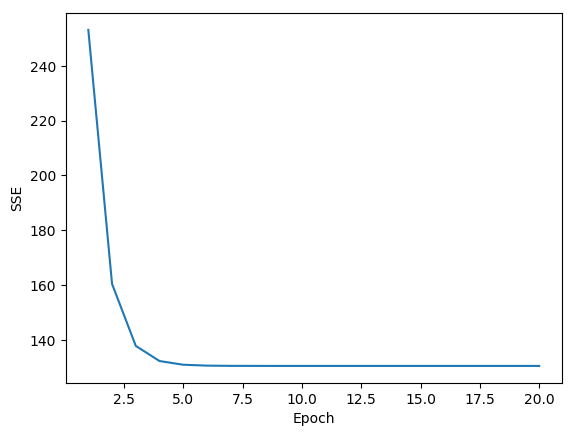

In [149]:
# 画出代价函数的图像
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')


In [150]:
def lin_regplot(X, y, model):
    plt.scatter(X, y)
    plt.plot(X, model.predict(X),color='red')
    return None


Text(0, 0.5, "Price in $1000's [MEDV] (standardized)")

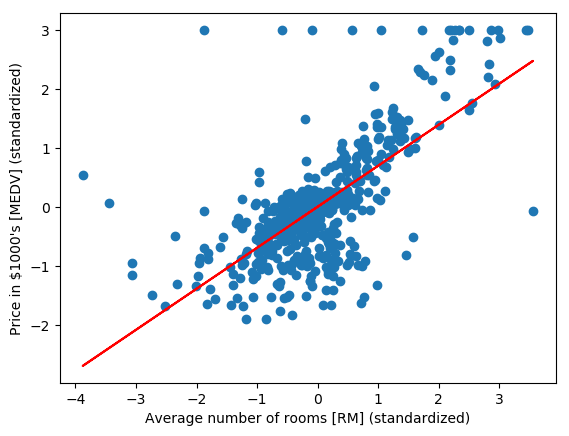

In [151]:
lin_regplot(X_std,y_std,lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')

In [152]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: {:.3f}".format(sc_y.inverse_transform(price_std)[0]))


Price in $1000's: 10.840


In [153]:
print('Slope: {:.3f}'.format(lr.w_[1]))
print('Intercept: {:.3f}'.format(lr.w_[0]))

Slope: 0.695
Intercept: -0.000


### 通过scikit-learn估算回归模型的系数

In [154]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: {:.3f}'.format(slr.intercept_))
print('Intercept: {:.3f}'.format(slr.coef_[0]))


Slope: -34.671
Intercept: 9.102


Text(0, 0.5, "Price in $1000's [MEDV] ")

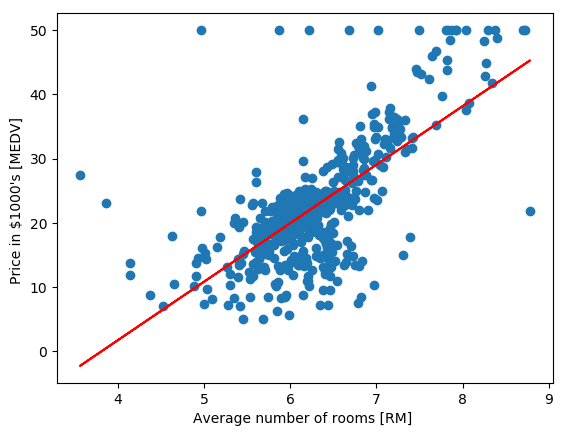

In [155]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM] ')
plt.ylabel('Price in $1000\'s [MEDV] ')


## 使用RANSAC拟合鲁棒的回归模型

RANSAC : RANdom SAmple Consensus

- 选择随机数量的样本作为内点并拟合模型
- 根据拟合模型测试所有其他数据点，并将那些落在用户给定公差范围内的点添加到内点
- 使用所有的内点重新拟合模型
- 估算拟合模型与内点的误差
- 如果性能满足某个用户定义的阈值或者已达到固定的迭代次数，则终止算法; 否则回到第1步

In [156]:
# 使用RANSAC
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50,
                         residual_threshold=5.0, loss='absolute_loss', random_state=0)
ransac.fit(X, y)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

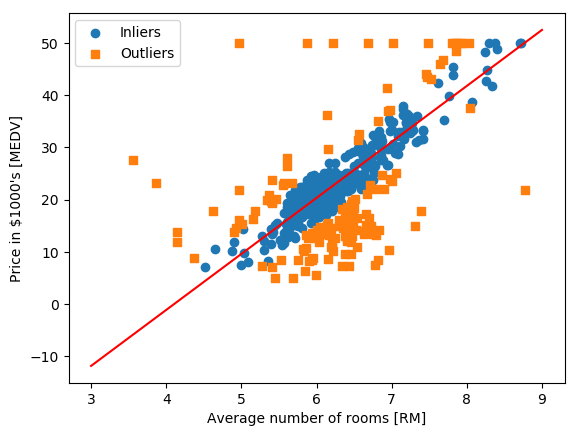

In [157]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')


In [158]:
print('Slope: {:.3f}'.format(ransac.estimator_.intercept_))
print('Intercept: {:.3f}'.format(ransac.estimator_.coef_[0]))

Slope: -44.089
Intercept: 10.735


## 评估线性回归模型的性能

In [159]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)


(-10, 50)

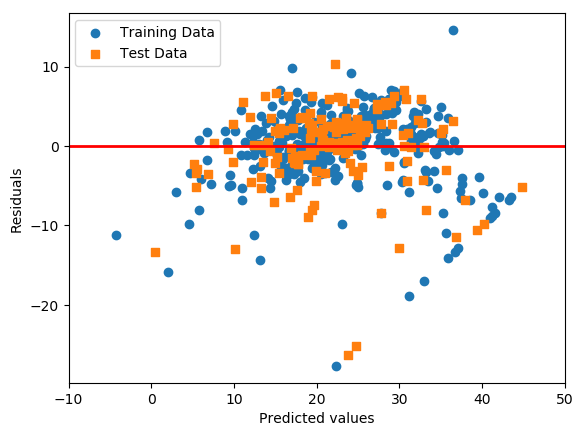

In [160]:
plt.scatter(y_train_pred, y_train_pred-y_train, marker='o', label='Training Data')
plt.scatter(y_test_pred, y_test_pred-y_test, marker='s', label='Test Data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])


$M S E=\frac{1}{n} \sum_{i=1}^{n}\left(y^{(i)}-\hat{y}^{(i)}\right)^{2}$

In [161]:
# MSE(mean squared error)
from sklearn.metrics import mean_squared_error
print('MSE train: {:.3f}, test: {:.3f} '.format(mean_squared_error(y_train, y_train_pred),
                                                mean_squared_error(y_test, y_test_pred)))


MSE train: 19.958, test: 27.196 


$R^{2}=1-\frac{S S E}{S S T}$


$1-\frac{\frac{1}{n} \sum_{i=1}^{n}\left(y^{(i)}-\hat{y}^{(i)}\right)^{2}}{\frac{1}{n} \sum_{i=1}^{n}\left(y^{(i)}-\mu_{y}\right)^{2}}$

$1-\frac{M S E}{\operatorname{Var}(y)}$

In [162]:
from sklearn.metrics import r2_score
print('R^2 train: {:.3f}, test: {:.3f} '.format(r2_score(y_train, y_train_pred),
                                                r2_score(y_test, y_test_pred)))


R^2 train: 0.765, test: 0.673 


## 为回归使用正则化方法

- Ridge
- LASSO
- Elastic Net

In [163]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)


In [164]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)


In [165]:
from sklearn.linear_model import ElasticNet
eln = ElasticNet(alpha=1.0, l1_ratio=0.5)


## 将线性回归模型转变为曲线-多项式回归

In [166]:
# 1.加入二次项
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)


In [167]:
# 2.拟合一个简单线性回归模型
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)


In [168]:
# 3.在多项式回归的变换特征上拟合多元回归模型
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))


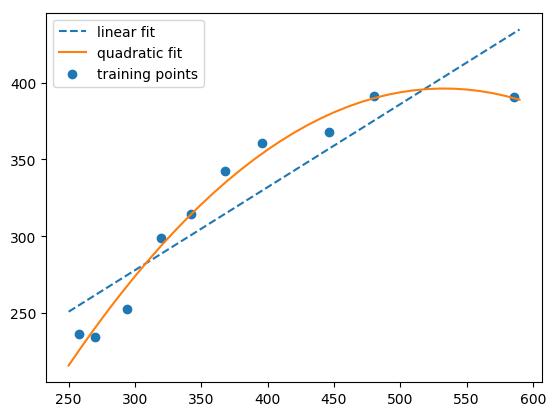

In [169]:
# 画出结果
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')


In [170]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: {:.3f}, quadratic: {:.3f} '.format(mean_squared_error(y, y_lin_pred),
                                                               mean_squared_error(y, y_quad_pred)))


Training MSE linear: 569.780, quadratic: 61.330 


In [171]:
print('Training R^2 linear: {:.3f}, quadratic: {:.3f} '.format(r2_score(y, y_lin_pred),
                                                               r2_score(y, y_quad_pred)))


Training R^2 linear: 0.832, quadratic: 0.982 


### 在房屋数据集上建立非线性关系的模型

In [172]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

In [173]:
# 创建多次向特征
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)


In [174]:
# 线性拟合
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))


In [175]:
# 平方拟合
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))


In [176]:
# 立方拟合
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


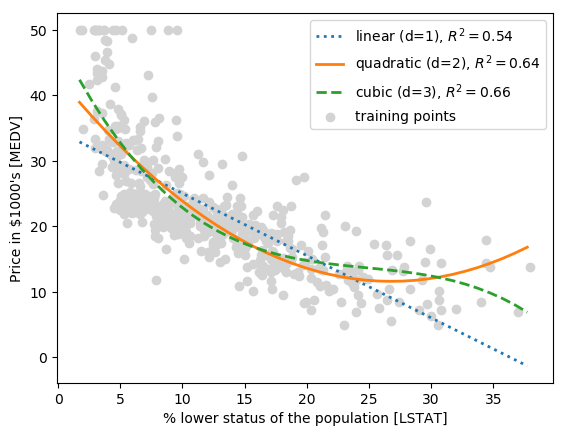

In [177]:
# 画出结果
plt.scatter(X, y, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2={:.2f}$'.format(linear_r2), lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label='quadratic (d=2), $R^2={:.2f}$'.format(quadratic_r2), lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label='cubic (d=3), $R^2={:.2f}$'.format(cubic_r2), lw=2, linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')


In [178]:
# 测试LSTAT的log值和MEDV的平方根值之间的关系
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# 拟合
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))


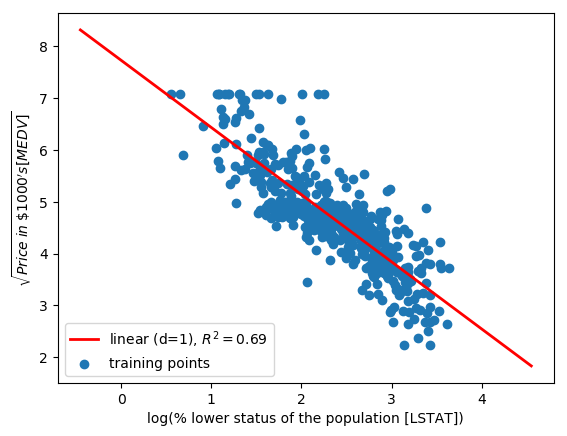

In [179]:
# 画出结果
plt.scatter(X_log, y_sqrt, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2={:.2f}$'.format(linear_r2), lw=2,color='red')
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')


### 使用随机森林处理非线性关系

#### 决策树回归

Text(0, 0.5, "Price in $1000's [MEDV]")

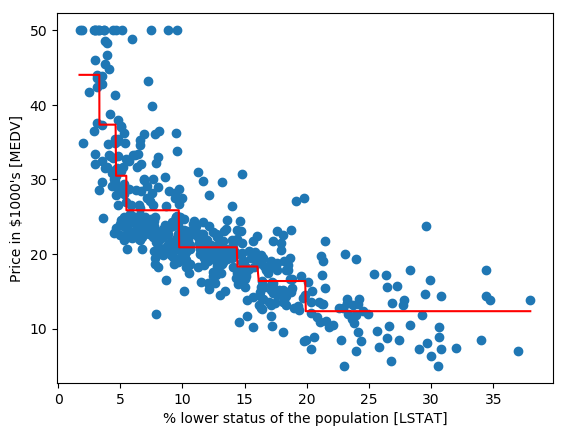

In [180]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')


#### 随机森林回归

In [181]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)


In [182]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: {:.3f}, test: {:.3f} '.format(mean_squared_error(y_train, y_train_pred),
                                                mean_squared_error(y_test, y_test_pred)))
print('R^2 train: {:.3f}, test: {:.3f} '.format(r2_score(y_train, y_train_pred),
                                                r2_score(y_test, y_test_pred)))


MSE train: 1.641, test: 11.056 
R^2 train: 0.979, test: 0.878 


(-10, 50)

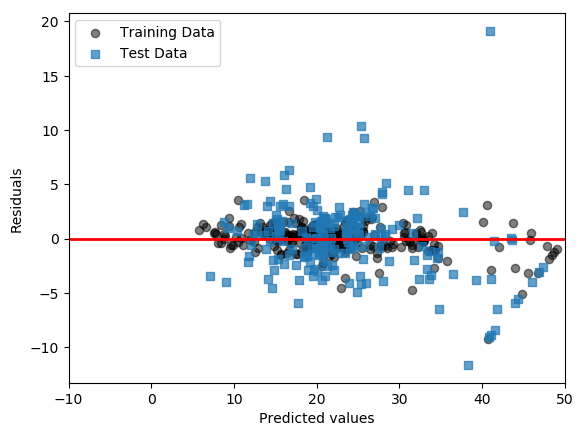

In [183]:
# residual of the prediction
plt.scatter(y_train_pred, y_train_pred-y_train, c='black', marker='o', alpha=0.5, s=35, label='Training Data')
plt.scatter(y_test_pred, y_test_pred-y_test, marker='s', alpha=0.7, s=35, label='Test Data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
